# Installation and Imports

In [ ]:
pip install -U sentence-transformers


In [ ]:
from torch.utils.data import DataLoader
import math
import logging
from datetime import datetime
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import nltk, re, string, collections
from nltk.util import ngrams
import re
import unicodedata
import nltk
from nltk.corpus import stopwords
import gensim
from tqdm import tqdm
tqdm.pandas(desc="progress-bar")
import sklearn
from sklearn.model_selection import train_test_split
import os
import gzip
import csv
import random
import keras
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.metrics import accuracy_score, confusion_matrix,classification_report
from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC
from sklearn.naive_bayes import MultinomialNB

In [ ]:
nltk.download('stopwords')
nltk.download('punkt')
nltk.download('wordnet')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

# Dataset Load

Loading the dataset in the system and concatinating them into one dataframe. With Fake being classified as with class 0 and real as class 1.

Loading the CSV

In [ ]:
fake = pd.read_csv('./Fake_New.csv')
real = pd.read_csv('./Real_New.csv')

fake['Target']=0
real['Target']=1

frames = [fake, real]

df = pd.concat(frames)
df = df.sample(frac=1).reset_index(drop=True)
df_=df.copy()
df_=df_.reset_index(drop=True)



In [ ]:
df_['news'] = df_['title']+' '+df_['text']
df_['news'] = df_['title']+' '+df_['text']
df_['news'] = df_.apply(lambda x: str(x['news']).lower(),axis=1)
df_["news"] = df_['news'].str.replace('[^\w\s]','')

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: FutureWarning: The default value of regex will change from True to False in a future version.
  after removing the cwd from sys.path.


In [ ]:
import matplotlib.pyplot as plt
df_.isna().sum()
from wordcloud import WordCloud

In [ ]:
df_.isna().sum()

text = " ".join(news for news in df_.news)

word_cloud = WordCloud(collocations = False, background_color = 'white').generate(text)

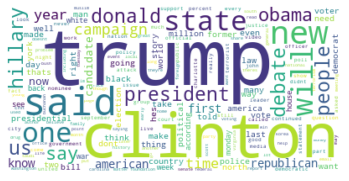

In [ ]:
plt.imshow(word_cloud, interpolation='bilinear')

plt.axis("off")

plt.show()

Split the data into testing and training datasets

In [ ]:
from sklearn.model_selection import train_test_split


X_train, X_test, y_train, y_test = train_test_split(df_['news'], 
                                                    df_['Target'], 
                                                    random_state=2,test_size=0.2)

# Sentence Embedding

Loading the model to get sentence embedding for all the data. The model is a pretrained model that uses the BERT deep learning model called SBERT. /cite the paper here

In [ ]:
import json
from sentence_transformers import SentenceTransformer, CrossEncoder, util
import gzip
import os
import torch

if not torch.cuda.is_available():
    print("Warning: No GPU found. Please add GPU to your notebook")


model_sentence_embedd = SentenceTransformer('all-MiniLM-L6-v2')

embeddings_train = model_sentence_embedd.encode(np.array(X_train))

embeddings_test = model_sentence_embedd.encode(np.array(X_test))

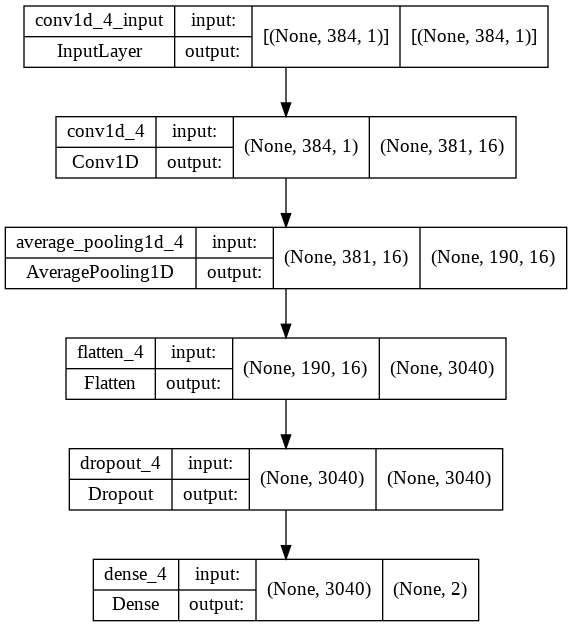

In [ ]:
from keras.utils.vis_utils import plot_model
plot_model(model, show_shapes=True, show_layer_names=True)

# Model for predection
The model will accept the embeddings as an input and give us the predection if the news is fake or real based on it

In [ ]:
embeddings_train = np.reshape(embeddings_train, embeddings_train.shape + (1,))
embeddings_test = np.reshape(embeddings_test, embeddings_test.shape + (1,))

In [ ]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras import layers
from tensorflow.keras.utils import to_categorical
from tensorflow.keras import regularizers

feature_vector_length = 384
num_classes = 2

input_shape = embeddings_train.shape

Y_train = to_categorical(y_train, num_classes)
Y_test = to_categorical(y_test, num_classes)

model = Sequential()
model.add(layers.Convolution1D(16,4,activation='relu'))
model.add(layers.AveragePooling1D())
model.add(layers.Flatten())
model.add(layers.Dropout(0.5))
model.add(layers.Dense(num_classes,kernel_regularizer=regularizers.l2(0.001),activation='sigmoid'))

# Training the model
Train the model on trainig data and embeddings

In [ ]:
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy',tf.keras.metrics.Precision(),tf.keras.metrics.Recall(),tf.keras.metrics.AUC()])
history = model.fit(embeddings_train, Y_train, epochs=10, batch_size=250, verbose=1, validation_split=0.1)

Epoch 1/10
2/2 [==============================] - 2s 559ms/step - loss: 0.6978 - accuracy: 0.5244 - precision_2: 0.5064 - recall_2: 0.7752 - auc_2: 0.4897 - val_loss: 0.6968 - val_accuracy: 0.5143 - val_precision_2: 0.5088 - val_recall_2: 0.8286 - val_auc_2: 0.5102
Epoch 2/10
2/2 [==============================] - 0s 39ms/step - loss: 0.6971 - accuracy: 0.5081 - precision_2: 0.5159 - recall_2: 0.7394 - auc_2: 0.5091 - val_loss: 0.6975 - val_accuracy: 0.5143 - val_precision_2: 0.5000 - val_recall_2: 0.8286 - val_auc_2: 0.5641
Epoch 3/10
2/2 [==============================] - 0s 43ms/step - loss: 0.6970 - accuracy: 0.4886 - precision_2: 0.5010 - recall_2: 0.7883 - auc_2: 0.5095 - val_loss: 0.6976 - val_accuracy: 0.4857 - val_precision_2: 0.4915 - val_recall_2: 0.8286 - val_auc_2: 0.5327
Epoch 4/10
2/2 [==============================] - 0s 40ms/step - loss: 0.6963 - accuracy: 0.5375 - precision_2: 0.5205 - recall_2: 0.7850 - auc_2: 0.5309 - val_loss: 0.6973 - val_accuracy: 0.4857 - val_pr

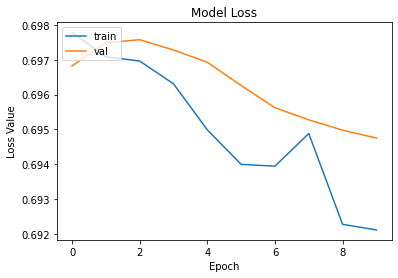

In [ ]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss Value')
plt.xlabel('Epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

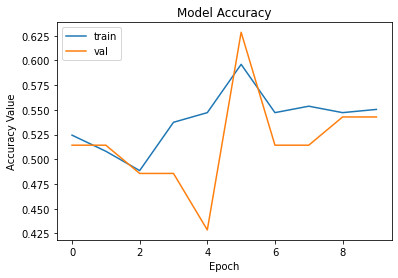

In [ ]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy Value')
plt.xlabel('Epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

# Testing the model
Testing the model with the test data

In [ ]:
test_results = model.evaluate(embeddings_test, Y_test, verbose=1)

3/3 [==============================] - 0s 6ms/step - loss: 0.6997 - accuracy: 0.4535 - precision_2: 0.4563 - recall_2: 0.5465 - auc_2: 0.4590


## Logistic Regression

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(df_['news'], 
                                                    df_['Target'], 
                                                    random_state=0)
pipe1 = Pipeline([('vect', CountVectorizer()), ('tfidf', TfidfTransformer()), ('model', LogisticRegression())])

model_lr = pipe1.fit(X_train, y_train)


In [ ]:
lr_pred = model_lr.predict(X_test)

print("Accuracy of Logistic Regression Classifier: {}%".format(round(accuracy_score(y_test, lr_pred)*100,2)))
print("\nConfusion Matrix of Logistic Regression Classifier:\n")
print(confusion_matrix(y_test, lr_pred))
print("\nCLassification Report of Logistic Regression Classifier:\n")
print(classification_report(y_test, lr_pred))

Accuracy of Logistic Regression Classifier: 37.38%

Confusion Matrix of Logistic Regression Classifier:

[[26 24]
 [43 14]]

CLassification Report of Logistic Regression Classifier:

              precision    recall  f1-score   support

           0       0.38      0.52      0.44        50
           1       0.37      0.25      0.29        57

    accuracy                           0.37       107
   macro avg       0.37      0.38      0.37       107
weighted avg       0.37      0.37      0.36       107



## SVM

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(df_['news'], 
                                                    df_['Target'], 
                                                    random_state=0)
pipe2 = Pipeline([('vect', CountVectorizer()), ('tfidf', TfidfTransformer()), ('model', LinearSVC())])

model_svc = pipe2.fit(X_train, y_train)
svc_pred = model_svc.predict(X_test)

print("Accuracy of SVM Classifier: {}%".format(round(accuracy_score(y_test, svc_pred)*100,2)))
print("\nConfusion Matrix of SVM Classifier:\n")
print(confusion_matrix(y_test, svc_pred))
print("\nClassification Report of SVM Classifier:\n")
print(classification_report(y_test, svc_pred))

Accuracy of SVM Classifier: 35.51%

Confusion Matrix of SVM Classifier:

[[24 26]
 [43 14]]

Classification Report of SVM Classifier:

              precision    recall  f1-score   support

           0       0.36      0.48      0.41        50
           1       0.35      0.25      0.29        57

    accuracy                           0.36       107
   macro avg       0.35      0.36      0.35       107
weighted avg       0.35      0.36      0.35       107



## Naive Bayes

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(df_['news'], 
                                                    df_['Target'], 
                                                    random_state=0)
pipe3 = Pipeline([('vect', CountVectorizer()), ('tfidf', TfidfTransformer()), ('model', MultinomialNB())])

model_nb = pipe3.fit(X_train, y_train)
nb_pred = model_nb.predict(X_test)

print("Accuracy of Naive Bayes Classifier: {}%".format(round(accuracy_score(y_test, nb_pred)*100,2)))
print("\nConfusion Matrix of Naive Bayes Classifier:\n")
print(confusion_matrix(y_test, nb_pred))
print("\nClassification Report of Naive Bayes Classifier:\n")
print(classification_report(y_test, nb_pred))

Accuracy of Naive Bayes Classifier: 34.58%

Confusion Matrix of Naive Bayes Classifier:

[[29 21]
 [49  8]]

Classification Report of Naive Bayes Classifier:

              precision    recall  f1-score   support

           0       0.37      0.58      0.45        50
           1       0.28      0.14      0.19        57

    accuracy                           0.35       107
   macro avg       0.32      0.36      0.32       107
weighted avg       0.32      0.35      0.31       107

